In [1]:
from itertools import chain
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

#fixes some bad rows and seperates data into train and test - note the seperation is not random, it should be.
#dependency collumns are split into rough lists for future
data = read_data()

def process_data(data):
    dataset = []
    feature_set = []
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)    
        deps = []
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            deps.append(organized_dependency)
        feature_set.append(deps)
        feature_set.append(sentence)
        dataset.append(feature_set)
        feature_set = []
    return dataset

p_data = pd.DataFrame(process_data(data))

C:\Users\lyonsl2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lyonsl2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\lyonsl2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\lyonsl2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minver

In [2]:
p_data.columns = ['type', 'gerund', 'rel_deps', 'sentence']

In [3]:
def count(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep:
            sum += 1
    return sum

def countGerund(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep and (t[1].endswith('ing') or t[3].endswith('ing')):
            sum += 1
    return sum

def countCC(x):
    return count('cc', x)
def countConj(x):
    return count('conj', x)
def countPunct(x):
    return count('punct', x)

def countGerundCC(x):
    return countGerund('cc', x)
def countGerundConj(x):
    return countGerund('conj', x)
def countGerundPunct(x):
    return countGerund('punct', x)


In [4]:
p_data['num_cc'] = p_data['rel_deps'].apply(countCC)
p_data['num_conj'] = p_data['rel_deps'].apply(countConj)
p_data['num_punct'] = p_data['rel_deps'].apply(countPunct)
p_data['num_gerund_cc'] = p_data['rel_deps'].apply(countGerundCC)
p_data['num_gerund_conj'] = p_data['rel_deps'].apply(countGerundConj)
p_data['num_gerund_punct'] = p_data['rel_deps'].apply(countGerundPunct)

In [5]:
p_data

,type,gerund,rel_deps,sentence,num_cc,num_conj,num_punct,num_gerund_cc,num_gerund_conj,num_gerund_punct
0,vp-ing,hearing,"[(xcomp, hearing, 5, remember, 4), (obj, phras...","I do n't remember hearing the phrase "" white g...",0,0,0,0,0,0
1,vp-ing,Growing,"[(advcl, Growing, 1, had, 10), (compound:prt, ...","Growing up black in the 1950s , I never had th...",0,0,0,0,0,0
2,vp-ing,having,"[(conj, irritability, 17, see, 3), (mark, at, ...","I can see now that possibly she was , but then...",0,1,0,0,0,0
3,vp-ing,feeling,"[(xcomp, feeling, 4, remember, 3), (obj, sympa...",I can remember feeling a certain sympathy for ...,0,0,0,0,0,0
4,vp-ing,drawing,"[(advcl, victimizing, 16, feeling, 4), (mark, ...",I can remember feeling a certain sympathy for ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
55054,vp-ing,restraining,"[(mark, for, 5, restraining, 6), (acl, restrai...",The main government tools for restraining both...,0,0,0,0,0,0
55055,vp-ing,restraining,"[(mark, In, 1, restraining, 2), (advcl, restra...","In restraining such growth , allocation by pri...",0,0,0,0,0,0
55056,vp-ing,learning,"[(obl, negotiations, 8, allow, 5), (punct, ,, ...","Therefore , change must allow for complex nego...",0,1,1,0,1,1
55057,vp-ing,creating,"[(mark, of, 7, creating, 8), (advcl, creating,...","Political wisdom , therefore , consists of cre...",0,0,0,0,0,0


In [6]:
p_data['type'].value_counts(normalize=True)

vp-ing         0.756643
acc-ing        0.108139
ing-of         0.054160
det-ing        0.053742
poss-ing       0.022685
poss-ing-of    0.004631
Name: type, dtype: float64

In [7]:
p_data[p_data['num_cc'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.865684
ing-of         0.057593
acc-ing        0.038661
det-ing        0.023715
poss-ing       0.010562
poss-ing-of    0.003786
Name: type, dtype: float64

In [8]:
p_data[p_data['num_conj'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.804588
acc-ing        0.078047
ing-of         0.049941
det-ing        0.042564
poss-ing       0.020729
poss-ing-of    0.004131
Name: type, dtype: float64

In [9]:
p_data[p_data['num_punct'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.855252
ing-of         0.049371
acc-ing        0.047309
det-ing        0.035916
poss-ing       0.009983
poss-ing-of    0.002170
Name: type, dtype: float64

In [10]:
p_data[p_data['num_gerund_cc'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.880748
ing-of         0.051998
acc-ing        0.034809
det-ing        0.019768
poss-ing       0.008595
poss-ing-of    0.004083
Name: type, dtype: float64

In [11]:
p_data[p_data['num_gerund_conj'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.833333
acc-ing        0.066607
ing-of         0.048277
det-ing        0.033754
poss-ing       0.014123
poss-ing-of    0.003906
Name: type, dtype: float64

In [12]:
p_data[p_data['num_gerund_punct'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.867680
ing-of         0.045506
acc-ing        0.043804
det-ing        0.033023
poss-ing       0.007717
poss-ing-of    0.002270
Name: type, dtype: float64

<AxesSubplot:>

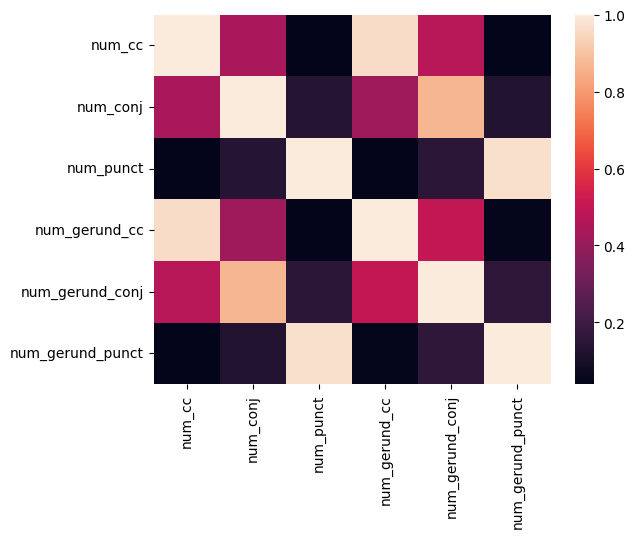

In [13]:
sns.heatmap(p_data.corr())

In [14]:
p_data[(p_data['num_gerund_cc'] > 0) & (p_data['num_gerund_conj'] > 0) & (p_data['num_gerund_punct'] > 0)]['sentence'].iloc[0]

'It is obvious that this was a rather shameful encounter for all concerned -- my friend and I , as his silent accomplice , trading on our racial pain , tampering with a stranger for no reason , and the stranger then buying his way out of the situation for twenty dollars , a sum that was generous by one count and cheap by another .'